In [1]:
import functools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split as _train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

In [2]:
sns.set_theme()

# Import CSV data

In [3]:
sheet_id = '1eb-NV5o-ed9DgS-tQuG_hL_MHVRaUKB1uT_889Uhg2k'
sheet_name = 'test'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
trips = pd.read_csv(url, parse_dates=['calc_created'])

In [4]:
trips.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


For convenience only, we take logarithm of the next columns

In [5]:
LOGCOLS = [
    'upfront_price', 'metered_price', 
    'predicted_distance', 'predicted_duration'
]

trips.loc[:, LOGCOLS] = np.log(trips[LOGCOLS])

Text(0, 0.5, 'log(metered_price)')

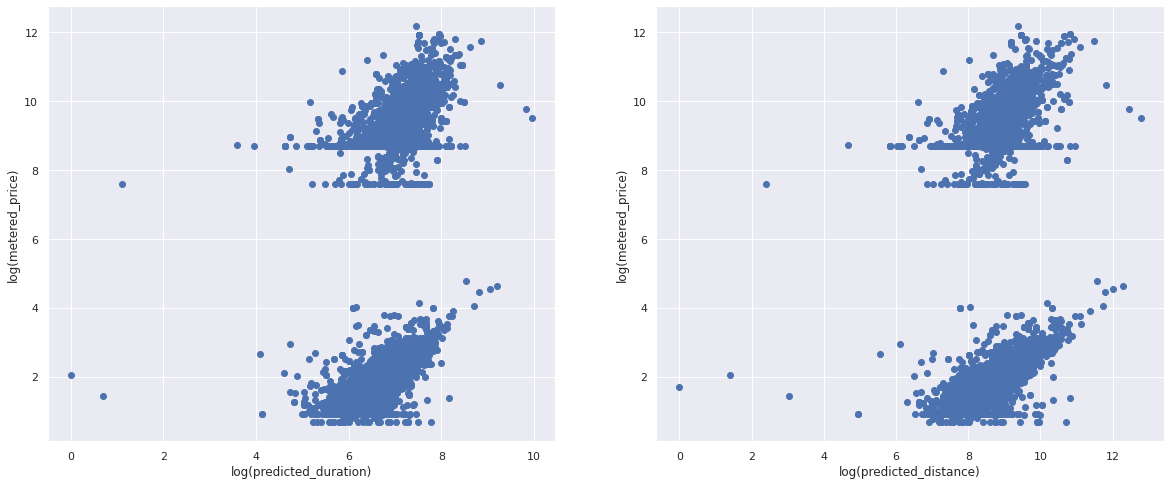

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'])
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'])
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')

/tmp/ipykernel_60076/806850964.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


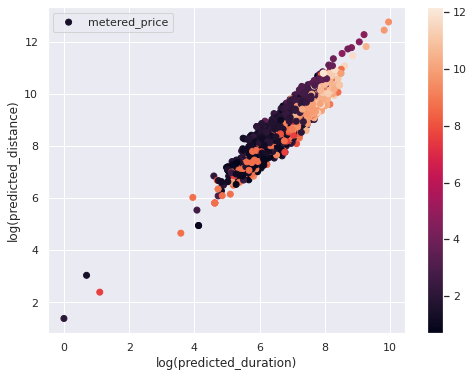

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(trips['predicted_duration'], 
            trips['predicted_distance'], 
            c=trips['metered_price'], 
            label='metered_price')
plt.xlabel('log(predicted_duration)')
plt.ylabel('log(predicted_distance)')
plt.colorbar()
plt.legend()

# Clean up the trips

In [8]:
trips.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score
count,4943.000000,4943.000000,4923.000000,3409.000000,4943.000000,4943.000000,4943.000000,4943.000000,4923.000000,4923.000000,4943.000000,0.0,4943.000000,4943.000000,4943.000000,2184.000000
mean,2061.074449,2061.074044,5.186442,3.680963,9769.223144,1566.230629,0.800728,1.119361,-inf,-inf,2471.000000,NaN,1093.311349,0.560388,0.068177,-674.046703
std,1199.298429,1199.299081,3.857424,3.402727,10912.426401,1650.329858,0.399493,0.499611,NaN,NaN,1427.065521,NaN,626.408069,0.496390,0.252075,1119.189890
min,0.000000,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,1.000000,-inf,-inf,0.000000,NaN,0.000000,0.000000,0.000000,-14225.000000
25%,1020.500000,1020.500000,1.682688,1.435085,3785.500000,604.000000,1.000000,1.000000,8.326154,6.392754,1235.500000,NaN,561.500000,0.000000,0.000000,-826.500000
50%,2065.000000,2065.000000,2.591516,1.887070,7140.000000,1054.000000,1.000000,1.000000,8.841882,6.844815,2471.000000,NaN,1088.000000,1.000000,0.000000,-278.500000
75%,3090.500000,3090.500000,9.304893,8.294050,11953.000000,1929.500000,1.000000,1.000000,9.275566,7.263330,3706.500000,NaN,1643.000000,1.000000,0.000000,-64.750000
max,4165.000000,4165.000000,12.178103,13.296317,233190.000000,22402.000000,1.000000,12.000000,12.775746,9.951897,4942.000000,NaN,2158.000000,1.000000,1.000000,49.000000


In [9]:
def clean_trips(trips):
    cond = trips['metered_price'].notna()  #  drop NaN from metered_price
    cond &= trips['predicted_distance'] > 0  #  predicted_distance has to be positive
    cond &= trips['predicted_duration'] > 0  #  predicted_duration has to be positive
    
    return trips.loc[cond]

In [10]:
trips = clean_trips(trips)

We are going to use 'upfront_price' column to calculate out baseline.

In [11]:
upfront_price = trips['upfront_price']

In [12]:
USECOLS = LOGCOLS
USECOLS.pop(USECOLS.index('upfront_price'))
USECOLS += [
    'calc_created', 'eu_indicator', 
    'gps_confidence', 'overpaid_ride_ticket', 
    'dest_change_number', 'prediction_price_type', 
    'change_reason_pricing'
]

In [13]:
trips = trips.loc[:, USECOLS]

# Add additional features

In [14]:
mask = trips['metered_price'].isin(np.log([2000, 6000, 2.5, 2]))

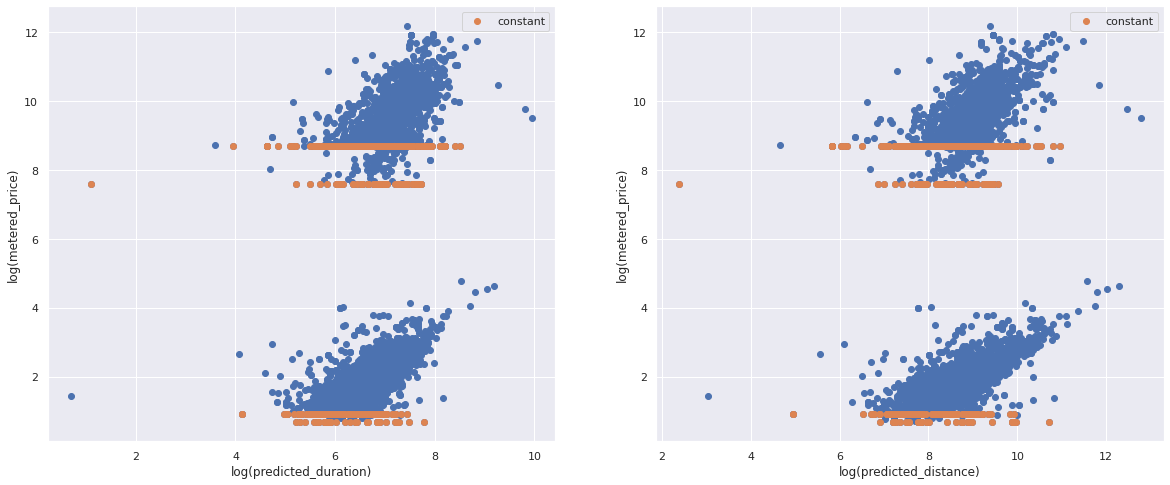

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'])
ax[0].scatter(trips.loc[mask, 'predicted_duration'], 
              trips.loc[mask, 'metered_price'],
              label='constant')
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[0].legend()
ax[1].scatter(trips['predicted_distance'], trips['metered_price'])
ax[1].scatter(trips.loc[mask, 'predicted_distance'], 
              trips.loc[mask, 'metered_price'],
              label='constant')
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')
ax[1].legend()

As you can see above there are some constants that don't change.
* log(2000) - some kind of airport
* log(6000) - some kind of airport
* log(2.5)
* log(2)

__Note. There is no any data leakage. All these constants can be derived from GPS coordinates.__

In [102]:
def add_features(_trips):
    trips = _trips.copy()
    CATEGORICAL_COLS = [
        'dayofweek', 'month', 
        'dest_change_number', 'prediction_price_type', 
        'change_reason_pricing'
    ]
    trips['dayofweek'] = trips['calc_created'].dt.dayofweek
    trips['month'] = trips['calc_created'].dt.month
    trips['hourofday'] = trips['calc_created'].dt.hour
    trips['isairport_2000'] = (trips['metered_price'] == np.log(2000)) * 1
    trips['isairport_6000'] = (trips['metered_price'] == np.log(6000)) * 1
    trips['2.5'] = (trips['metered_price'] == np.log(2.5)) * 1
    trips['2'] = (trips['metered_price'] == np.log(2)) * 1
    trips.loc[:, 'change_reason_pricing'] = trips['change_reason_pricing'].fillna('NONE')
    trips = pd.get_dummies(trips, columns=CATEGORICAL_COLS)
    trips.drop(columns=['calc_created'], inplace=True)
    
    return trips

In [103]:
features_trips = add_features(trips)

# Support functions

To compare quality of our models we are going to use RMSE metric.

In [104]:
def rmse_decorator(func):
    @functools.wraps(func)
    def wrapper_rmse(*args, **kwargs):
        if len(args) == 3:
            return make_scorer(func)(*args, **kwargs) 
        else:
            return func(*args, **kwargs)
    
    return wrapper_rmse


@rmse_decorator
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [105]:
def train_test_split(features, labels, train_size=.8, test_size=.2, **params):
    X, y = {}, {}
    
    X['train'], X['test'], y['train'], y['test'] = _train_test_split(
        features, 
        labels, 
        test_size=test_size, 
        train_size=train_size, 
        **params
    )
    
    return X, y
    
def train_valid_test_split(features, labels, train_size=.6, test_size=.2, valid_size=.2, **params):
    X, y = {}, {}
    
    X_train_valid, X['test'], y_train_valid, y['test'] = _train_test_split(
        features, 
        labels, 
        test_size=test_size, 
        train_size=train_size + valid_size,
        **params
    )
    X['train'], X['valid'], y['train'], y['valid'] = _train_test_split(
        X_train_valid, 
        y_train_valid, 
        test_size=valid_size, 
        train_size=train_size + test_size, 
        **params
    )
        
    return X, y

In [106]:
def print_results(estimator, X_test, y_test):
    print('R^2 = {:.5f}'.format(estimator.score(X_test, y_test)))
    print('RMSE = {:.5f}'.format(rmse(estimator, X_test, y_test)))
    mask = upfront_price[y_test.index].notna()
    baseline = rmse(y_test.loc[mask], upfront_price[y_test.index].loc[mask])
    print('Baseline RMSE = {:.5f}'.format(baseline))

In [133]:
def plot_results(X, y_pred, features_trips):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    idx = X['test'].index
    ax[0].scatter(features_trips.loc[idx, 'predicted_duration'], 
                  features_trips.loc[idx, 'metered_price'], 
                  label='test')
    ax[0].scatter(X['test']['predicted_duration'], y_pred, label='pred')
    ax[0].set_xlabel('log(predicted_duration)')
    ax[0].set_ylabel('log(metered_price)')
    ax[0].legend()
    ax[1].scatter(features_trips.loc[idx, 'predicted_distance'], 
                  features_trips.loc[idx, 'metered_price'], 
                  label='test')
    ax[1].scatter(X['test']['predicted_distance'], y_pred, label='pred')
    ax[1].set_xlabel('log(predicted_distance)')
    ax[1].set_ylabel('log(metered_price)')
    ax[1].legend()

# Linear model

In [128]:
labels = features_trips.loc[:, 'metered_price']
features = features_trips.drop(columns=['metered_price'])

X, y = train_test_split(features, labels, random_state=42)

In [129]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[7, 10, 11, 15, 18, 20]))
]
ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X['train'], y['train'])
print('best_alpha = {}'.format(ridge_pipe['ridge'].alpha_))
print_results(ridge_pipe, X['test'], y['test'])
y_pred = ridge_pipe.predict(X['test'])

best_alpha = 15
R^2 = 0.98832
RMSE = 0.41472
Baseline RMSE = 0.41872


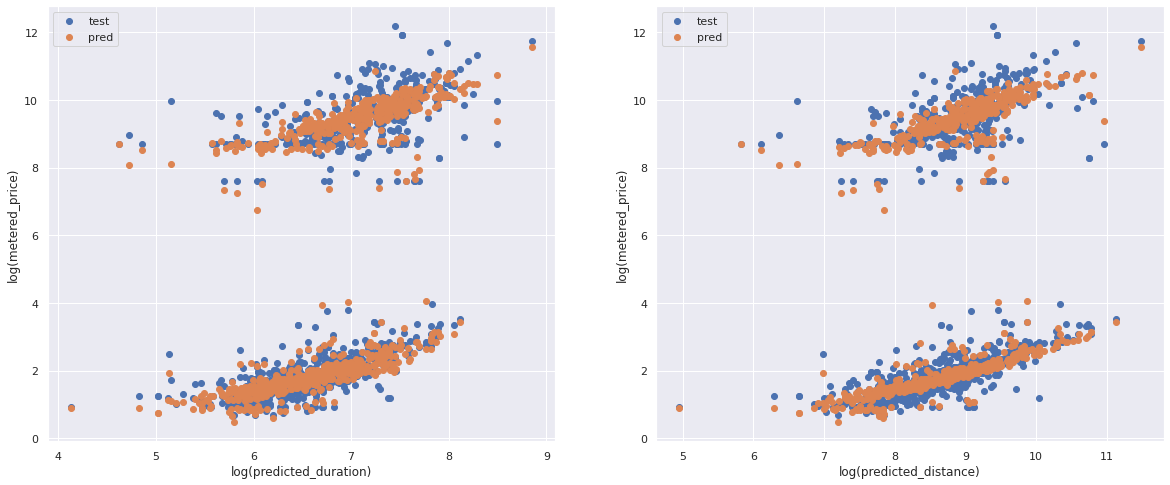

In [135]:
plot_results(X, y_pred, features_trips)

## LGBM

In [136]:
labels = features_trips.loc[:, 'metered_price']
features = features_trips.drop(columns=['metered_price'])

X, y = train_valid_test_split(features, labels, random_state=42)

In [137]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
]
lgb_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'n_estimators': [50, 70, 80, 100],
    'early_stopping_rounds': [20]
}


# lightgbm.early_stopping(stopping_rounds
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(lgb_pipe.fit_transform(X['train']), y['train'], 
                eval_set=[(lgb_pipe.transform(X['valid']), y['valid'])], 
                eval_metric='rmse')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.50247	valid_0's l2: 12.2673
[2]	valid_0's rmse: 3.17135	valid_0's l2: 10.0575
[3]	valid_0's rmse: 2.87487	valid_0's l2: 8.26486
[4]	valid_0's rmse: 2.60969	valid_0's l2: 6.81046
[5]	valid_0's rmse: 2.37282	valid_0's l2: 5.63026
[6]	valid_0's rmse: 2.16157	valid_0's l2: 4.67238
[7]	valid_0's rmse: 1.97352	valid_0's l2: 3.89476
[8]	valid_0's rmse: 1.80647	valid_0's l2: 3.26334
[9]	valid_0's rmse: 1.65846	valid_0's l2: 2.75048
[10]	valid_0's rmse: 1.52768	valid_0's l2: 2.3338
[11]	valid_0's rmse: 1.4125	valid_0's l2: 1.99515
[12]	valid_0's rmse: 1.31142	valid_0's l2: 1.71983
[13]	valid_0's rmse: 1.22307	valid_0's l2: 1.49589
[14]	valid_0's rmse: 1.14616	valid_0's l2: 1.31368
[15]	valid_0's rmse: 1.07951	valid_0's l2: 1.16534
[16]	valid_0's rmse: 1.02201	valid_0's l2: 1.04451

[1]	valid_0's rmse: 3.50276	valid_0's l2: 12.2693
[2]	valid_0's rmse: 3.17105	valid_0's l2: 10.0556
[3]	valid_0's rmse: 2.87405	valid_0's l2: 8.26015
[4]	valid_0's rmse: 2.60841	valid_0's l2: 6.80378
[5]	valid_0's rmse: 2.37113	valid_0's l2: 5.62228
[6]	valid_0's rmse: 2.15953	valid_0's l2: 4.66359
[7]	valid_0's rmse: 1.97118	valid_0's l2: 3.88555
[8]	valid_0's rmse: 1.80388	valid_0's l2: 3.25399
[9]	valid_0's rmse: 1.65566	valid_0's l2: 2.74121
[10]	valid_0's rmse: 1.52472	valid_0's l2: 2.32477
[11]	valid_0's rmse: 1.40942	valid_0's l2: 1.98646
[12]	valid_0's rmse: 1.30826	valid_0's l2: 1.71155
[13]	valid_0's rmse: 1.21987	valid_0's l2: 1.48807
[14]	valid_0's rmse: 1.14295	valid_0's l2: 1.30634
[15]	valid_0's rmse: 1.07633	valid_0's l2: 1.15849
[16]	valid_0's rmse: 1.01889	valid_0's l2: 1.03814
[17]	valid_0's rmse: 0.969611	valid_0's l2: 0.940145
[18]	valid_0's rmse: 0.927521	valid_0's l2: 0.860295
[19]	valid_0's rmse: 0.892265	valid_0's l2: 0.796137
[20]	valid_0's rmse: 0.861451	vali

[1]	valid_0's rmse: 3.50064	valid_0's l2: 12.2544
[2]	valid_0's rmse: 3.16883	valid_0's l2: 10.0415
[3]	valid_0's rmse: 2.87173	valid_0's l2: 8.24685
[4]	valid_0's rmse: 2.60602	valid_0's l2: 6.79133
[5]	valid_0's rmse: 2.36869	valid_0's l2: 5.61068
[6]	valid_0's rmse: 2.15704	valid_0's l2: 4.65282
[7]	valid_0's rmse: 1.96865	valid_0's l2: 3.87559
[8]	valid_0's rmse: 1.80133	valid_0's l2: 3.2448
[9]	valid_0's rmse: 1.6531	valid_0's l2: 2.73274
[10]	valid_0's rmse: 1.52216	valid_0's l2: 2.31698
[11]	valid_0's rmse: 1.40688	valid_0's l2: 1.97932
[12]	valid_0's rmse: 1.30576	valid_0's l2: 1.705
[13]	valid_0's rmse: 1.21741	valid_0's l2: 1.48208
[14]	valid_0's rmse: 1.14055	valid_0's l2: 1.30085
[15]	valid_0's rmse: 1.074	valid_0's l2: 1.15347
[16]	valid_0's rmse: 1.01664	valid_0's l2: 1.03356
[17]	valid_0's rmse: 0.967448	valid_0's l2: 0.935955
[18]	valid_0's rmse: 0.925454	valid_0's l2: 0.856465
[19]	valid_0's rmse: 0.88977	valid_0's l2: 0.791691
[20]	valid_0's rmse: 0.859088	valid_0's l

[1]	valid_0's rmse: 3.49799	valid_0's l2: 12.2359
[2]	valid_0's rmse: 3.16497	valid_0's l2: 10.0171
[3]	valid_0's rmse: 2.86681	valid_0's l2: 8.2186
[4]	valid_0's rmse: 2.60015	valid_0's l2: 6.7608
[5]	valid_0's rmse: 2.362	valid_0's l2: 5.57903
[6]	valid_0's rmse: 2.14964	valid_0's l2: 4.62095
[7]	valid_0's rmse: 1.96065	valid_0's l2: 3.84413
[8]	valid_0's rmse: 1.79282	valid_0's l2: 3.21422
[9]	valid_0's rmse: 1.64419	valid_0's l2: 2.70337
[10]	valid_0's rmse: 1.51295	valid_0's l2: 2.28902
[11]	valid_0's rmse: 1.39746	valid_0's l2: 1.95289
[12]	valid_0's rmse: 1.29621	valid_0's l2: 1.68017
[13]	valid_0's rmse: 1.20783	valid_0's l2: 1.45886
[14]	valid_0's rmse: 1.13103	valid_0's l2: 1.27923
[15]	valid_0's rmse: 1.06461	valid_0's l2: 1.1334
[16]	valid_0's rmse: 1.00746	valid_0's l2: 1.01498
[17]	valid_0's rmse: 0.958537	valid_0's l2: 0.918792
[18]	valid_0's rmse: 0.916864	valid_0's l2: 0.840639
[19]	valid_0's rmse: 0.881734	valid_0's l2: 0.777455
[20]	valid_0's rmse: 0.851375	valid_0's

[1]	valid_0's rmse: 3.50064	valid_0's l2: 12.2544
[2]	valid_0's rmse: 3.16883	valid_0's l2: 10.0415
[3]	valid_0's rmse: 2.87173	valid_0's l2: 8.24685
[4]	valid_0's rmse: 2.60602	valid_0's l2: 6.79133
[5]	valid_0's rmse: 2.36869	valid_0's l2: 5.61068
[6]	valid_0's rmse: 2.15704	valid_0's l2: 4.65282
[7]	valid_0's rmse: 1.96865	valid_0's l2: 3.87559
[8]	valid_0's rmse: 1.80133	valid_0's l2: 3.2448
[9]	valid_0's rmse: 1.6531	valid_0's l2: 2.73274
[10]	valid_0's rmse: 1.52216	valid_0's l2: 2.31698
[11]	valid_0's rmse: 1.40688	valid_0's l2: 1.97932
[12]	valid_0's rmse: 1.30576	valid_0's l2: 1.705
[13]	valid_0's rmse: 1.21741	valid_0's l2: 1.48208
[14]	valid_0's rmse: 1.14055	valid_0's l2: 1.30085
[15]	valid_0's rmse: 1.074	valid_0's l2: 1.15347
[16]	valid_0's rmse: 1.01664	valid_0's l2: 1.03356
[17]	valid_0's rmse: 0.967448	valid_0's l2: 0.935955
[18]	valid_0's rmse: 0.925454	valid_0's l2: 0.856465
[19]	valid_0's rmse: 0.88977	valid_0's l2: 0.791691
[20]	valid_0's rmse: 0.859088	valid_0's l

[1]	valid_0's rmse: 3.50276	valid_0's l2: 12.2693
[2]	valid_0's rmse: 3.17105	valid_0's l2: 10.0556
[3]	valid_0's rmse: 2.87405	valid_0's l2: 8.26015
[4]	valid_0's rmse: 2.60841	valid_0's l2: 6.80378
[5]	valid_0's rmse: 2.37113	valid_0's l2: 5.62228
[6]	valid_0's rmse: 2.15953	valid_0's l2: 4.66359
[7]	valid_0's rmse: 1.97118	valid_0's l2: 3.88555
[8]	valid_0's rmse: 1.80388	valid_0's l2: 3.25399
[9]	valid_0's rmse: 1.65566	valid_0's l2: 2.74121
[10]	valid_0's rmse: 1.52472	valid_0's l2: 2.32477
[11]	valid_0's rmse: 1.40942	valid_0's l2: 1.98646
[12]	valid_0's rmse: 1.30826	valid_0's l2: 1.71155
[13]	valid_0's rmse: 1.21987	valid_0's l2: 1.48807
[14]	valid_0's rmse: 1.14295	valid_0's l2: 1.30634
[15]	valid_0's rmse: 1.07633	valid_0's l2: 1.15849
[16]	valid_0's rmse: 1.01889	valid_0's l2: 1.03814
[17]	valid_0's rmse: 0.969611	valid_0's l2: 0.940145
[18]	valid_0's rmse: 0.927521	valid_0's l2: 0.860295
[19]	valid_0's rmse: 0.892265	valid_0's l2: 0.796137
[20]	valid_0's rmse: 0.861451	vali

[1]	valid_0's rmse: 3.50247	valid_0's l2: 12.2673
[2]	valid_0's rmse: 3.17135	valid_0's l2: 10.0575
[3]	valid_0's rmse: 2.87487	valid_0's l2: 8.26486
[4]	valid_0's rmse: 2.60969	valid_0's l2: 6.81046
[5]	valid_0's rmse: 2.37282	valid_0's l2: 5.63026
[6]	valid_0's rmse: 2.16157	valid_0's l2: 4.67238
[7]	valid_0's rmse: 1.97352	valid_0's l2: 3.89476
[8]	valid_0's rmse: 1.80647	valid_0's l2: 3.26334
[9]	valid_0's rmse: 1.65846	valid_0's l2: 2.75048
[10]	valid_0's rmse: 1.52768	valid_0's l2: 2.3338
[11]	valid_0's rmse: 1.4125	valid_0's l2: 1.99515
[12]	valid_0's rmse: 1.31142	valid_0's l2: 1.71983
[13]	valid_0's rmse: 1.22307	valid_0's l2: 1.49589
[14]	valid_0's rmse: 1.14616	valid_0's l2: 1.31368
[15]	valid_0's rmse: 1.07951	valid_0's l2: 1.16534
[16]	valid_0's rmse: 1.02201	valid_0's l2: 1.04451
[17]	valid_0's rmse: 0.972646	valid_0's l2: 0.946041
[18]	valid_0's rmse: 0.930449	valid_0's l2: 0.865735
[19]	valid_0's rmse: 0.895128	valid_0's l2: 0.801254
[20]	valid_0's rmse: 0.864147	valid_

[8]	valid_0's rmse: 1.79961	valid_0's l2: 3.23861
[9]	valid_0's rmse: 1.65115	valid_0's l2: 2.72631
[10]	valid_0's rmse: 1.52002	valid_0's l2: 2.31046
[11]	valid_0's rmse: 1.40458	valid_0's l2: 1.97284
[12]	valid_0's rmse: 1.30333	valid_0's l2: 1.69866
[13]	valid_0's rmse: 1.21488	valid_0's l2: 1.47594
[14]	valid_0's rmse: 1.13796	valid_0's l2: 1.29496
[15]	valid_0's rmse: 1.07138	valid_0's l2: 1.14785
[16]	valid_0's rmse: 1.01401	valid_0's l2: 1.02822
[17]	valid_0's rmse: 0.964836	valid_0's l2: 0.930909
[18]	valid_0's rmse: 0.922881	valid_0's l2: 0.851709
[19]	valid_0's rmse: 0.887253	valid_0's l2: 0.787218
[20]	valid_0's rmse: 0.85726	valid_0's l2: 0.734895
[21]	valid_0's rmse: 0.828824	valid_0's l2: 0.686949
[22]	valid_0's rmse: 0.804003	valid_0's l2: 0.64642
[23]	valid_0's rmse: 0.781147	valid_0's l2: 0.61019
[24]	valid_0's rmse: 0.761723	valid_0's l2: 0.580223
[25]	valid_0's rmse: 0.742666	valid_0's l2: 0.551553
[26]	valid_0's rmse: 0.725943	valid_0's l2: 0.526993
[27]	valid_0's r

[1]	valid_0's rmse: 3.49799	valid_0's l2: 12.2359
[2]	valid_0's rmse: 3.16497	valid_0's l2: 10.0171
[3]	valid_0's rmse: 2.86681	valid_0's l2: 8.2186
[4]	valid_0's rmse: 2.60015	valid_0's l2: 6.7608
[5]	valid_0's rmse: 2.362	valid_0's l2: 5.57903
[6]	valid_0's rmse: 2.14964	valid_0's l2: 4.62095
[7]	valid_0's rmse: 1.96065	valid_0's l2: 3.84413
[8]	valid_0's rmse: 1.79282	valid_0's l2: 3.21422
[9]	valid_0's rmse: 1.64419	valid_0's l2: 2.70337
[10]	valid_0's rmse: 1.51295	valid_0's l2: 2.28902
[11]	valid_0's rmse: 1.39746	valid_0's l2: 1.95289
[12]	valid_0's rmse: 1.29621	valid_0's l2: 1.68017
[13]	valid_0's rmse: 1.20783	valid_0's l2: 1.45886
[14]	valid_0's rmse: 1.13103	valid_0's l2: 1.27923
[15]	valid_0's rmse: 1.06461	valid_0's l2: 1.1334
[16]	valid_0's rmse: 1.00746	valid_0's l2: 1.01498
[17]	valid_0's rmse: 0.958537	valid_0's l2: 0.918792
[18]	valid_0's rmse: 0.916864	valid_0's l2: 0.840639
[19]	valid_0's rmse: 0.881734	valid_0's l2: 0.777455
[20]	valid_0's rmse: 0.851375	valid_0's

[1]	valid_0's rmse: 3.49131	valid_0's l2: 12.1893
[2]	valid_0's rmse: 3.15072	valid_0's l2: 9.92703
[3]	valid_0's rmse: 2.84519	valid_0's l2: 8.09508
[4]	valid_0's rmse: 2.57036	valid_0's l2: 6.60674
[5]	valid_0's rmse: 2.32392	valid_0's l2: 5.40061
[6]	valid_0's rmse: 2.10299	valid_0's l2: 4.42259
[7]	valid_0's rmse: 1.90529	valid_0's l2: 3.63014
[8]	valid_0's rmse: 1.72906	valid_0's l2: 2.98965
[9]	valid_0's rmse: 1.57091	valid_0's l2: 2.46776
[10]	valid_0's rmse: 1.42932	valid_0's l2: 2.04296
[11]	valid_0's rmse: 1.30252	valid_0's l2: 1.69656
[12]	valid_0's rmse: 1.19014	valid_0's l2: 1.41644
[13]	valid_0's rmse: 1.09017	valid_0's l2: 1.18848
[14]	valid_0's rmse: 1.00143	valid_0's l2: 1.00287
[15]	valid_0's rmse: 0.924147	valid_0's l2: 0.854048
[16]	valid_0's rmse: 0.855758	valid_0's l2: 0.732322
[17]	valid_0's rmse: 0.795463	valid_0's l2: 0.632761
[18]	valid_0's rmse: 0.743874	valid_0's l2: 0.553349
[19]	valid_0's rmse: 0.698088	valid_0's l2: 0.487327
[20]	valid_0's rmse: 0.658783	

[1]	valid_0's rmse: 3.49107	valid_0's l2: 12.1875
[2]	valid_0's rmse: 3.15073	valid_0's l2: 9.92711
[3]	valid_0's rmse: 2.84501	valid_0's l2: 8.09409
[4]	valid_0's rmse: 2.57018	valid_0's l2: 6.60583
[5]	valid_0's rmse: 2.3245	valid_0's l2: 5.40331
[6]	valid_0's rmse: 2.10428	valid_0's l2: 4.42798
[7]	valid_0's rmse: 1.90631	valid_0's l2: 3.63401
[8]	valid_0's rmse: 1.73027	valid_0's l2: 2.99384
[9]	valid_0's rmse: 1.57169	valid_0's l2: 2.47021
[10]	valid_0's rmse: 1.43031	valid_0's l2: 2.04578
[11]	valid_0's rmse: 1.30473	valid_0's l2: 1.70232
[12]	valid_0's rmse: 1.19228	valid_0's l2: 1.42153
[13]	valid_0's rmse: 1.09238	valid_0's l2: 1.19329
[14]	valid_0's rmse: 1.00442	valid_0's l2: 1.00887
[15]	valid_0's rmse: 0.927481	valid_0's l2: 0.860221
[16]	valid_0's rmse: 0.859675	valid_0's l2: 0.739041
[17]	valid_0's rmse: 0.800232	valid_0's l2: 0.640371
[18]	valid_0's rmse: 0.747783	valid_0's l2: 0.55918
[19]	valid_0's rmse: 0.702357	valid_0's l2: 0.493306
[20]	valid_0's rmse: 0.662553	va

[1]	valid_0's rmse: 3.49268	valid_0's l2: 12.1988
[2]	valid_0's rmse: 3.15187	valid_0's l2: 9.93427
[3]	valid_0's rmse: 2.84561	valid_0's l2: 8.09749
[4]	valid_0's rmse: 2.57105	valid_0's l2: 6.61031
[5]	valid_0's rmse: 2.32432	valid_0's l2: 5.40248
[6]	valid_0's rmse: 2.10302	valid_0's l2: 4.42271
[7]	valid_0's rmse: 1.90487	valid_0's l2: 3.62853
[8]	valid_0's rmse: 1.7274	valid_0's l2: 2.9839
[9]	valid_0's rmse: 1.56982	valid_0's l2: 2.46432
[10]	valid_0's rmse: 1.4288	valid_0's l2: 2.04147
[11]	valid_0's rmse: 1.30269	valid_0's l2: 1.69699
[12]	valid_0's rmse: 1.19003	valid_0's l2: 1.41618
[13]	valid_0's rmse: 1.09123	valid_0's l2: 1.19079
[14]	valid_0's rmse: 1.00366	valid_0's l2: 1.00733
[15]	valid_0's rmse: 0.925802	valid_0's l2: 0.857109
[16]	valid_0's rmse: 0.857606	valid_0's l2: 0.735488
[17]	valid_0's rmse: 0.796936	valid_0's l2: 0.635107
[18]	valid_0's rmse: 0.744204	valid_0's l2: 0.55384
[19]	valid_0's rmse: 0.699704	valid_0's l2: 0.489585
[20]	valid_0's rmse: 0.661035	vali

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49422	valid_0's l2: 12.2096
[2]	valid_0's rmse: 3.15402	valid_0's l2: 9.94787
[3]	valid_0's rmse: 2.84784	valid_0's l2: 8.11017
[4]	valid_0's rmse: 2.57375	valid_0's l2: 6.62417
[5]	valid_0's rmse: 2.32758	valid_0's l2: 5.41765
[6]	valid_0's rmse: 2.10749	valid_0's l2: 4.4415
[7]	valid_0's rmse: 1.91077	valid_0's l2: 3.65105
[8]	valid_0's rmse: 1.7339	valid_0's l2: 3.00642
[9]	valid_0's rmse: 1.57543	valid_0's l2: 2.48199
[10]	valid_0's rmse: 1.43338	valid_0's l2: 2.05458
[11]	valid_0's rmse: 1.30764	valid_0's l2: 1.70992
[12]	valid_0's rmse: 1.19536	valid_0's l2: 1.42888
[13]	valid_0's rmse: 1.09584	valid_0's l2: 1.20086
[14]	valid_0's rmse: 1.00712	valid_0's l2: 1.01429
[15]	valid_0's rmse: 0.928658	valid_0's l2: 0.862406
[16]	valid_0's rmse: 0.860315	valid_0's l2: 0.740142
[17]	valid_0's rmse: 0.799559	valid_0's l2: 0.639295
[18]

[1]	valid_0's rmse: 3.49268	valid_0's l2: 12.1988
[2]	valid_0's rmse: 3.15187	valid_0's l2: 9.93427
[3]	valid_0's rmse: 2.84561	valid_0's l2: 8.09749
[4]	valid_0's rmse: 2.57105	valid_0's l2: 6.61031
[5]	valid_0's rmse: 2.32432	valid_0's l2: 5.40248
[6]	valid_0's rmse: 2.10302	valid_0's l2: 4.42271
[7]	valid_0's rmse: 1.90487	valid_0's l2: 3.62853
[8]	valid_0's rmse: 1.7274	valid_0's l2: 2.9839
[9]	valid_0's rmse: 1.56982	valid_0's l2: 2.46432
[10]	valid_0's rmse: 1.4288	valid_0's l2: 2.04147
[11]	valid_0's rmse: 1.30269	valid_0's l2: 1.69699
[12]	valid_0's rmse: 1.19003	valid_0's l2: 1.41618
[13]	valid_0's rmse: 1.09123	valid_0's l2: 1.19079
[14]	valid_0's rmse: 1.00366	valid_0's l2: 1.00733
[15]	valid_0's rmse: 0.925802	valid_0's l2: 0.857109
[16]	valid_0's rmse: 0.857606	valid_0's l2: 0.735488
[17]	valid_0's rmse: 0.796936	valid_0's l2: 0.635107
[18]	valid_0's rmse: 0.744204	valid_0's l2: 0.55384
[19]	valid_0's rmse: 0.699704	valid_0's l2: 0.489585
[20]	valid_0's rmse: 0.661035	vali

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49107	valid_0's l2: 12.1875
[2]	valid_0's rmse: 3.15073	valid_0's l2: 9.92711
[3]	valid_0's rmse: 2.84501	valid_0's l2: 8.09409
[4]	valid_0's rmse: 2.57018	valid_0's l2: 6.60583
[5]	valid_0's rmse: 2.3245	valid_0's l2: 5.40331
[6]	valid_0's rmse: 2.10428	valid_0's l2: 4.42798
[7]	valid_0's rmse: 1.90631	valid_0's l2: 3.63401
[8]	valid_0's rmse: 1.73027	valid_0's l2: 2.99384
[9]	valid_0's rmse: 1.57169	valid_0's l2: 2.47021
[10]	valid_0's rmse: 1.43031	valid_0's l2: 2.04578
[11]	valid_0's rmse: 1.30473	valid_0's l2: 1.70232
[12]	valid_0's rmse: 1.19228	valid_0's l2: 1.42153
[13]	valid_0's rmse: 1.09238	valid_0's l2: 1.19329
[14]	valid_0's rmse: 1.00442	valid_0's l2: 1.00887
[15]	valid_0's rmse: 0.927481	valid_0's l2: 0.860221
[16]	valid_0's rmse: 0.859675	valid_0's l2: 0.739041
[17]	valid_0's rmse: 0.800232	valid_0's l2: 0.640371
[18

[1]	valid_0's rmse: 3.49131	valid_0's l2: 12.1893
[2]	valid_0's rmse: 3.15072	valid_0's l2: 9.92703
[3]	valid_0's rmse: 2.84519	valid_0's l2: 8.09508
[4]	valid_0's rmse: 2.57036	valid_0's l2: 6.60674
[5]	valid_0's rmse: 2.32392	valid_0's l2: 5.40061
[6]	valid_0's rmse: 2.10299	valid_0's l2: 4.42259
[7]	valid_0's rmse: 1.90529	valid_0's l2: 3.63014
[8]	valid_0's rmse: 1.72906	valid_0's l2: 2.98965
[9]	valid_0's rmse: 1.57091	valid_0's l2: 2.46776
[10]	valid_0's rmse: 1.42932	valid_0's l2: 2.04296
[11]	valid_0's rmse: 1.30252	valid_0's l2: 1.69656
[12]	valid_0's rmse: 1.19014	valid_0's l2: 1.41644
[13]	valid_0's rmse: 1.09017	valid_0's l2: 1.18848
[14]	valid_0's rmse: 1.00143	valid_0's l2: 1.00287
[15]	valid_0's rmse: 0.924147	valid_0's l2: 0.854048
[16]	valid_0's rmse: 0.855758	valid_0's l2: 0.732322
[17]	valid_0's rmse: 0.795463	valid_0's l2: 0.632761
[18]	valid_0's rmse: 0.743874	valid_0's l2: 0.553349
[19]	valid_0's rmse: 0.698088	valid_0's l2: 0.487327
[20]	valid_0's rmse: 0.658783	

[1]	valid_0's rmse: 3.49437	valid_0's l2: 12.2106
[2]	valid_0's rmse: 3.15373	valid_0's l2: 9.94601
[3]	valid_0's rmse: 2.8477	valid_0's l2: 8.10937
[4]	valid_0's rmse: 2.57349	valid_0's l2: 6.62284
[5]	valid_0's rmse: 2.32676	valid_0's l2: 5.4138
[6]	valid_0's rmse: 2.1057	valid_0's l2: 4.43398
[7]	valid_0's rmse: 1.90819	valid_0's l2: 3.64119
[8]	valid_0's rmse: 1.73129	valid_0's l2: 2.99736
[9]	valid_0's rmse: 1.57368	valid_0's l2: 2.47646
[10]	valid_0's rmse: 1.43302	valid_0's l2: 2.05355
[11]	valid_0's rmse: 1.30738	valid_0's l2: 1.70925
[12]	valid_0's rmse: 1.19457	valid_0's l2: 1.42699
[13]	valid_0's rmse: 1.09532	valid_0's l2: 1.19973
[14]	valid_0's rmse: 1.00659	valid_0's l2: 1.01322
[15]	valid_0's rmse: 0.928433	valid_0's l2: 0.861987
[16]	valid_0's rmse: 0.859675	valid_0's l2: 0.739041
[17]	valid_0's rmse: 0.799484	valid_0's l2: 0.639175
[18]	valid_0's rmse: 0.747493	valid_0's l2: 0.558746
[19]	valid_0's rmse: 0.702148	valid_0's l2: 0.493012
[20]	valid_0's rmse: 0.662818	val

[1]	valid_0's rmse: 3.49243	valid_0's l2: 12.197
[2]	valid_0's rmse: 3.15127	valid_0's l2: 9.93049
[3]	valid_0's rmse: 2.84546	valid_0's l2: 8.09665
[4]	valid_0's rmse: 2.57164	valid_0's l2: 6.61335
[5]	valid_0's rmse: 2.3253	valid_0's l2: 5.40704
[6]	valid_0's rmse: 2.10444	valid_0's l2: 4.42869
[7]	valid_0's rmse: 1.90619	valid_0's l2: 3.63357
[8]	valid_0's rmse: 1.72814	valid_0's l2: 2.98648
[9]	valid_0's rmse: 1.5695	valid_0's l2: 2.46333
[10]	valid_0's rmse: 1.42678	valid_0's l2: 2.0357
[11]	valid_0's rmse: 1.29973	valid_0's l2: 1.6893
[12]	valid_0's rmse: 1.1869	valid_0's l2: 1.40873
[13]	valid_0's rmse: 1.08684	valid_0's l2: 1.18123
[14]	valid_0's rmse: 0.999334	valid_0's l2: 0.998668
[15]	valid_0's rmse: 0.921033	valid_0's l2: 0.848301
[16]	valid_0's rmse: 0.852499	valid_0's l2: 0.726755
[17]	valid_0's rmse: 0.792057	valid_0's l2: 0.627355
[18]	valid_0's rmse: 0.738966	valid_0's l2: 0.546071
[19]	valid_0's rmse: 0.692377	valid_0's l2: 0.479386
[20]	valid_0's rmse: 0.652117	vali

[50]	valid_0's rmse: 0.426454	valid_0's l2: 0.181863
[CV] END early_stopping_rounds=20, max_depth=10, n_estimators=50; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42455	valid_0's l2: 2.02934
[11]	valid_0's rmse: 1.29824	valid_0's l2: 1.68542
[12]	valid_0's rmse: 1.18526	valid_0's l2: 1.40484
[13]	valid_0's rmse: 1.0849	valid_0's l2: 1.17701
[14]	valid_0's rmse: 0.99643	valid_0's l2: 0.992873
[15]	valid_0's rmse: 0.917

[45]	valid_0's rmse: 0.429555	valid_0's l2: 0.184517
[46]	valid_0's rmse: 0.429068	valid_0's l2: 0.184099
[47]	valid_0's rmse: 0.427884	valid_0's l2: 0.183085
[48]	valid_0's rmse: 0.42806	valid_0's l2: 0.183236
[49]	valid_0's rmse: 0.427823	valid_0's l2: 0.183032
[50]	valid_0's rmse: 0.427492	valid_0's l2: 0.18275
[51]	valid_0's rmse: 0.427108	valid_0's l2: 0.182421
[52]	valid_0's rmse: 0.426886	valid_0's l2: 0.182231
[53]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[54]	valid_0's rmse: 0.426519	valid_0's l2: 0.181919
[55]	valid_0's rmse: 0.42634	valid_0's l2: 0.181766
[56]	valid_0's rmse: 0.426322	valid_0's l2: 0.181751
[57]	valid_0's rmse: 0.426396	valid_0's l2: 0.181814
[58]	valid_0's rmse: 0.426802	valid_0's l2: 0.18216
[59]	valid_0's rmse: 0.426817	valid_0's l2: 0.182173
[60]	valid_0's rmse: 0.42681	valid_0's l2: 0.182167
[61]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[62]	valid_0's rmse: 0.427067	valid_0's l2: 0.182386
[63]	valid_0's rmse: 0.427159	valid_0's l2: 0.18246

[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42455	valid_0's l2: 2.02934
[11]	valid_0's rmse: 1.29824	valid_0's l2: 1.68542
[12]	valid_0's rmse: 1.18526	valid_0's l2: 1.40484
[13]	valid_0's rmse: 1.0849	valid_0's l2: 1.17701
[14]	valid_0's rmse: 0.99643	valid_0's l2: 0.992873
[15]	valid_0's rmse: 0.917859	valid_0's l2: 0.842465
[16]	valid_0's rmse: 0.849217	valid_0's l2: 0.721169
[17]	valid_0's rmse: 0.789437	valid_0's l2: 0.623212
[18]	valid_0's rmse: 0.737315	valid_0's l2: 0.543633
[19]	valid_0's rmse: 0.691316	valid_0's l2: 0.477918
[20]	valid_0's rmse: 0.652035	val

[49]	valid_0's rmse: 0.427823	valid_0's l2: 0.183032
[50]	valid_0's rmse: 0.427492	valid_0's l2: 0.18275
[51]	valid_0's rmse: 0.427108	valid_0's l2: 0.182421
[52]	valid_0's rmse: 0.426886	valid_0's l2: 0.182231
[53]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[54]	valid_0's rmse: 0.426519	valid_0's l2: 0.181919
[55]	valid_0's rmse: 0.42634	valid_0's l2: 0.181766
[56]	valid_0's rmse: 0.426322	valid_0's l2: 0.181751
[57]	valid_0's rmse: 0.426396	valid_0's l2: 0.181814
[58]	valid_0's rmse: 0.426802	valid_0's l2: 0.18216
[59]	valid_0's rmse: 0.426817	valid_0's l2: 0.182173
[60]	valid_0's rmse: 0.42681	valid_0's l2: 0.182167
[61]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[62]	valid_0's rmse: 0.427067	valid_0's l2: 0.182386
[63]	valid_0's rmse: 0.427159	valid_0's l2: 0.182465
[64]	valid_0's rmse: 0.42703	valid_0's l2: 0.182354
[65]	valid_0's rmse: 0.426888	valid_0's l2: 0.182233
[66]	valid_0's rmse: 0.426988	valid_0's l2: 0.182319
[67]	valid_0's rmse: 0.427275	valid_0's l2: 0.18256

[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42455	valid_0's l2: 2.02934
[11]	valid_0's rmse: 1.29824	valid_0's l2: 1.68542
[12]	valid_0's rmse: 1.18526	valid_0's l2: 1.40484
[13]	valid_0's rmse: 1.0849	valid_0's l2: 1.17701
[14]	valid_0's rmse: 0.99643	valid_0's l2: 0.992873
[15]	valid_0's rmse: 0.917859	valid_0's l2: 0.842465
[16]	valid_0's rmse: 0.849217	valid_0's l2: 0.721169
[17]	valid_0's rmse: 0.789437	valid_0's l2: 0.623212
[18]	valid_0's rmse: 0.737315	valid_0's l2: 0.543633
[19]	valid_0's rmse: 0.691316	valid_0's l2: 0.477918
[20]	valid_0's rmse: 0.652035	val

[52]	valid_0's rmse: 0.426886	valid_0's l2: 0.182231
[53]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[54]	valid_0's rmse: 0.426519	valid_0's l2: 0.181919
[55]	valid_0's rmse: 0.42634	valid_0's l2: 0.181766
[56]	valid_0's rmse: 0.426322	valid_0's l2: 0.181751
[57]	valid_0's rmse: 0.426396	valid_0's l2: 0.181814
[58]	valid_0's rmse: 0.426802	valid_0's l2: 0.18216
[59]	valid_0's rmse: 0.426817	valid_0's l2: 0.182173
[60]	valid_0's rmse: 0.42681	valid_0's l2: 0.182167
[61]	valid_0's rmse: 0.426831	valid_0's l2: 0.182185
[62]	valid_0's rmse: 0.427067	valid_0's l2: 0.182386
[63]	valid_0's rmse: 0.427159	valid_0's l2: 0.182465
[64]	valid_0's rmse: 0.42703	valid_0's l2: 0.182354
[65]	valid_0's rmse: 0.426888	valid_0's l2: 0.182233
[66]	valid_0's rmse: 0.426988	valid_0's l2: 0.182319
[67]	valid_0's rmse: 0.427275	valid_0's l2: 0.182564
[68]	valid_0's rmse: 0.427192	valid_0's l2: 0.182493
[69]	valid_0's rmse: 0.427019	valid_0's l2: 0.182345
[70]	valid_0's rmse: 0.426859	valid_0's l2: 0.1822

[63]	valid_0's rmse: 0.42558	valid_0's l2: 0.181118
[64]	valid_0's rmse: 0.4253	valid_0's l2: 0.18088
[65]	valid_0's rmse: 0.425408	valid_0's l2: 0.180972
[66]	valid_0's rmse: 0.425055	valid_0's l2: 0.180671
[67]	valid_0's rmse: 0.424838	valid_0's l2: 0.180487
[68]	valid_0's rmse: 0.424522	valid_0's l2: 0.180219
[69]	valid_0's rmse: 0.424552	valid_0's l2: 0.180244
[70]	valid_0's rmse: 0.424674	valid_0's l2: 0.180348
[71]	valid_0's rmse: 0.424847	valid_0's l2: 0.180495
[72]	valid_0's rmse: 0.424877	valid_0's l2: 0.180521
[73]	valid_0's rmse: 0.425083	valid_0's l2: 0.180695
[74]	valid_0's rmse: 0.425447	valid_0's l2: 0.181005
[75]	valid_0's rmse: 0.425329	valid_0's l2: 0.180905
[76]	valid_0's rmse: 0.425353	valid_0's l2: 0.180925
[77]	valid_0's rmse: 0.425445	valid_0's l2: 0.181003
[78]	valid_0's rmse: 0.425288	valid_0's l2: 0.18087
[79]	valid_0's rmse: 0.425443	valid_0's l2: 0.181002
[80]	valid_0's rmse: 0.425388	valid_0's l2: 0.180955
[81]	valid_0's rmse: 0.425451	valid_0's l2: 0.18100

[51]	valid_0's rmse: 0.4299	valid_0's l2: 0.184814
[52]	valid_0's rmse: 0.43031	valid_0's l2: 0.185166
[53]	valid_0's rmse: 0.430331	valid_0's l2: 0.185185
[54]	valid_0's rmse: 0.43057	valid_0's l2: 0.185391
[55]	valid_0's rmse: 0.430696	valid_0's l2: 0.185499
[56]	valid_0's rmse: 0.430696	valid_0's l2: 0.185499
[57]	valid_0's rmse: 0.430962	valid_0's l2: 0.185728
[58]	valid_0's rmse: 0.430912	valid_0's l2: 0.185685
[59]	valid_0's rmse: 0.431022	valid_0's l2: 0.18578
[60]	valid_0's rmse: 0.431086	valid_0's l2: 0.185836
[61]	valid_0's rmse: 0.431104	valid_0's l2: 0.18585
[62]	valid_0's rmse: 0.430832	valid_0's l2: 0.185616
[63]	valid_0's rmse: 0.430781	valid_0's l2: 0.185572
[64]	valid_0's rmse: 0.430798	valid_0's l2: 0.185587
[65]	valid_0's rmse: 0.431096	valid_0's l2: 0.185844
[66]	valid_0's rmse: 0.431312	valid_0's l2: 0.18603
[67]	valid_0's rmse: 0.431356	valid_0's l2: 0.186068
[68]	valid_0's rmse: 0.431254	valid_0's l2: 0.18598
[69]	valid_0's rmse: 0.43132	valid_0's l2: 0.186037
[7

[49]	valid_0's rmse: 0.425564	valid_0's l2: 0.181105
[50]	valid_0's rmse: 0.42508	valid_0's l2: 0.180693
[CV] END early_stopping_rounds=20, max_depth=20, n_estimators=50; total time=   0.5s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42459	valid_0's l2: 2.02947
[11]	valid_0's rmse: 1.29799	valid_0's l2: 1.68477
[12]	valid_0's rmse: 1.18476	valid_0's l2: 1.40366
[13]	valid_0's rmse: 1.08402	valid_0's l2: 1.17509
[14]	valid_0's rmse: 0.99

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49033	valid_0's l2: 12.1824
[2]	valid_0's rmse: 3.14936	valid_0's l2: 9.91847
[3]	valid_0's rmse: 2.84297	valid_0's l2: 8.08246
[4]	valid_0's rmse: 2.56717	valid_0's l2: 6.59037
[5]	valid_0's rmse: 2.32059	valid_0's l2: 5.38512
[6]	valid_0's rmse: 2.09943	valid_0's l2: 4.40761
[7]	valid_0's rmse: 1.90135	valid_0's l2: 3.61513
[8]	valid_0's rmse: 1.72493	valid_0's l2: 2.97539
[9]	valid_0's rmse: 1.56615	valid_0's l2: 2.45283
[10]	valid_0's rmse: 1.42448	valid_0's l2: 2.02913
[11]	valid_0's rmse: 1.29805	valid_0's l2: 1.68493
[12]	valid_0's rmse: 1.18542	valid_0's l2: 1.40522
[13]	valid_0's rmse: 1.08577	valid_0's l2: 1.1789
[14]	valid_0's rmse: 0.996981	valid_0's l2: 0.99397
[15]	valid_0's rmse: 0.918382	valid_0's l2: 0.843425
[16]	valid_0's rmse: 0.849014	valid_0's l2: 0.720825
[17]	valid_0's rmse: 0.788709	valid_0's l2: 0.622063
[1

[43]	valid_0's rmse: 0.435914	valid_0's l2: 0.190021
[44]	valid_0's rmse: 0.435096	valid_0's l2: 0.189308
[45]	valid_0's rmse: 0.43512	valid_0's l2: 0.189329
[46]	valid_0's rmse: 0.434735	valid_0's l2: 0.188994
[47]	valid_0's rmse: 0.434318	valid_0's l2: 0.188632
[48]	valid_0's rmse: 0.434054	valid_0's l2: 0.188403
[49]	valid_0's rmse: 0.433971	valid_0's l2: 0.188331
[50]	valid_0's rmse: 0.433963	valid_0's l2: 0.188324
[51]	valid_0's rmse: 0.433299	valid_0's l2: 0.187748
[52]	valid_0's rmse: 0.433147	valid_0's l2: 0.187616
[53]	valid_0's rmse: 0.432947	valid_0's l2: 0.187443
[54]	valid_0's rmse: 0.432619	valid_0's l2: 0.187159
[55]	valid_0's rmse: 0.43305	valid_0's l2: 0.187532
[56]	valid_0's rmse: 0.433539	valid_0's l2: 0.187956
[57]	valid_0's rmse: 0.433695	valid_0's l2: 0.188091
[58]	valid_0's rmse: 0.433957	valid_0's l2: 0.188318
[59]	valid_0's rmse: 0.434397	valid_0's l2: 0.188701
[60]	valid_0's rmse: 0.43469	valid_0's l2: 0.188956
[61]	valid_0's rmse: 0.434951	valid_0's l2: 0.189

[71]	valid_0's rmse: 0.426748	valid_0's l2: 0.182114
[72]	valid_0's rmse: 0.427004	valid_0's l2: 0.182332
[73]	valid_0's rmse: 0.426802	valid_0's l2: 0.18216
[74]	valid_0's rmse: 0.426913	valid_0's l2: 0.182255
[75]	valid_0's rmse: 0.42662	valid_0's l2: 0.182004
[76]	valid_0's rmse: 0.426337	valid_0's l2: 0.181763
[CV] END early_stopping_rounds=20, max_depth=20, n_estimators=80; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49033	valid_0's l2: 12.1824
[2]	valid_0's rmse: 3.14936	valid_0's l2: 9.91847
[3]	valid_0's rmse: 2.84297	valid_0's l2: 8.08246
[4]	valid_0's rmse: 2.56717	valid_0's l2: 6.59037
[5]	valid_0's rmse: 2.32059	valid_0's l2: 5.38512
[6]	valid_0's rmse: 2.09943	valid_0's l2: 4.40761
[7]	valid_0's rmse: 1.90135	valid_0's l2: 3.61513
[8]	valid_0's rmse: 1.72493	valid_0's l2: 2.97539
[9]	valid_0's rmse: 1.56615	valid_0's l2: 2.45283
[10]	valid_0's 

[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42459	valid_0's l2: 2.02947
[11]	valid_0's rmse: 1.29799	valid_0's l2: 1.68477
[12]	valid_0's rmse: 1.18476	valid_0's l2: 1.40366
[13]	valid_0's rmse: 1.08402	valid_0's l2: 1.17509
[14]	valid_0's rmse: 0.995165	valid_0's l2: 0.990354
[15]	valid_0's rmse: 0.916535	valid_0's l2: 0.840037
[16]	valid_0's rmse: 0.847921	valid_0's l2: 0.71897
[17]	valid_0's rmse: 0.788178	valid_0's l2: 0.621224
[18]	valid_0's rmse: 0.735289	valid_0's l2: 0.540649
[19]	valid_0's rmse: 0.69003	valid_0's l2: 0.476142
[20]	valid_0's rmse: 0.649867	val

[1]	valid_0's rmse: 3.49243	valid_0's l2: 12.197
[2]	valid_0's rmse: 3.15127	valid_0's l2: 9.93049
[3]	valid_0's rmse: 2.84546	valid_0's l2: 8.09665
[4]	valid_0's rmse: 2.57164	valid_0's l2: 6.61335
[5]	valid_0's rmse: 2.3253	valid_0's l2: 5.40704
[6]	valid_0's rmse: 2.10444	valid_0's l2: 4.42869
[7]	valid_0's rmse: 1.90619	valid_0's l2: 3.63357
[8]	valid_0's rmse: 1.72814	valid_0's l2: 2.98648
[9]	valid_0's rmse: 1.5695	valid_0's l2: 2.46333
[10]	valid_0's rmse: 1.42678	valid_0's l2: 2.0357
[11]	valid_0's rmse: 1.29999	valid_0's l2: 1.68998
[12]	valid_0's rmse: 1.18711	valid_0's l2: 1.40922
[13]	valid_0's rmse: 1.08691	valid_0's l2: 1.18138
[14]	valid_0's rmse: 0.999266	valid_0's l2: 0.998533
[15]	valid_0's rmse: 0.921949	valid_0's l2: 0.84999
[16]	valid_0's rmse: 0.852632	valid_0's l2: 0.726982
[17]	valid_0's rmse: 0.791416	valid_0's l2: 0.62634
[18]	valid_0's rmse: 0.737872	valid_0's l2: 0.544456
[19]	valid_0's rmse: 0.692515	valid_0's l2: 0.479577
[20]	valid_0's rmse: 0.652638	vali

[1]	valid_0's rmse: 3.49193	valid_0's l2: 12.1936
[2]	valid_0's rmse: 3.14994	valid_0's l2: 9.92215
[3]	valid_0's rmse: 2.84239	valid_0's l2: 8.07916
[4]	valid_0's rmse: 2.56721	valid_0's l2: 6.59059
[5]	valid_0's rmse: 2.32002	valid_0's l2: 5.38251
[6]	valid_0's rmse: 2.09759	valid_0's l2: 4.39987
[7]	valid_0's rmse: 1.89879	valid_0's l2: 3.60539
[8]	valid_0's rmse: 1.7212	valid_0's l2: 2.96252
[9]	valid_0's rmse: 1.56249	valid_0's l2: 2.44137
[10]	valid_0's rmse: 1.42053	valid_0's l2: 2.01792
[11]	valid_0's rmse: 1.29291	valid_0's l2: 1.67162
[12]	valid_0's rmse: 1.17965	valid_0's l2: 1.39158
[13]	valid_0's rmse: 1.07906	valid_0's l2: 1.16437
[14]	valid_0's rmse: 0.990269	valid_0's l2: 0.980632
[15]	valid_0's rmse: 0.911593	valid_0's l2: 0.831001
[16]	valid_0's rmse: 0.842465	valid_0's l2: 0.709747
[17]	valid_0's rmse: 0.781532	valid_0's l2: 0.610793
[18]	valid_0's rmse: 0.729034	valid_0's l2: 0.531491
[19]	valid_0's rmse: 0.68357	valid_0's l2: 0.467269
[20]	valid_0's rmse: 0.644545	

[CV] END early_stopping_rounds=20, max_depth=20, n_estimators=100; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.48945	valid_0's l2: 12.1762
[2]	valid_0's rmse: 3.14832	valid_0's l2: 9.91192
[3]	valid_0's rmse: 2.84257	valid_0's l2: 8.08023
[4]	valid_0's rmse: 2.56762	valid_0's l2: 6.59266
[5]	valid_0's rmse: 2.32082	valid_0's l2: 5.38619
[6]	valid_0's rmse: 2.09912	valid_0's l2: 4.4063
[7]	valid_0's rmse: 1.9009	valid_0's l2: 3.61341
[8]	valid_0's rmse: 1.72413	valid_0's l2: 2.97261
[9]	valid_0's rmse: 1.56615	valid_0's l2: 2.45284
[10]	valid_0's rmse: 1.425	valid_0's l2: 2.03062
[11]	valid_0's rmse: 1.29948	valid_0's l2: 1.68865
[12]	valid_0's rmse: 1.18715	valid_0's l2: 1.40932
[13]	valid_0's rmse: 1.08703	valid_0's l2: 1.18162
[14]	valid_0's rmse: 0.998809	valid_0's l2: 0.997619
[15]	valid_0's rmse: 0.919626	valid_0's l2: 0.845712
[16]	valid_0's rmse: 0.8

[40]	valid_0's rmse: 0.432506	valid_0's l2: 0.187062
[41]	valid_0's rmse: 0.431087	valid_0's l2: 0.185836
[42]	valid_0's rmse: 0.430005	valid_0's l2: 0.184904
[43]	valid_0's rmse: 0.429633	valid_0's l2: 0.184585
[44]	valid_0's rmse: 0.428661	valid_0's l2: 0.18375
[45]	valid_0's rmse: 0.427952	valid_0's l2: 0.183143
[46]	valid_0's rmse: 0.427574	valid_0's l2: 0.18282
[47]	valid_0's rmse: 0.426956	valid_0's l2: 0.182291
[48]	valid_0's rmse: 0.426727	valid_0's l2: 0.182096
[49]	valid_0's rmse: 0.426535	valid_0's l2: 0.181932
[50]	valid_0's rmse: 0.426356	valid_0's l2: 0.181779
[CV] END early_stopping_rounds=20, max_depth=30, n_estimators=50; total time=   0.5s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49193	valid_0's l2: 12.1936
[2]	valid_0's rmse: 3.14994	valid_0's l2: 9.92215
[3]	valid_0's rmse: 2.84239	valid_0's l2: 8.07916
[4]	valid_0's rmse: 2.56721	valid_0's l2: 6.59059


[43]	valid_0's rmse: 0.432715	valid_0's l2: 0.187242
[44]	valid_0's rmse: 0.432206	valid_0's l2: 0.186802
[45]	valid_0's rmse: 0.431568	valid_0's l2: 0.186251
[46]	valid_0's rmse: 0.431714	valid_0's l2: 0.186377
[47]	valid_0's rmse: 0.431377	valid_0's l2: 0.186086
[48]	valid_0's rmse: 0.431203	valid_0's l2: 0.185936
[49]	valid_0's rmse: 0.430734	valid_0's l2: 0.185532
[50]	valid_0's rmse: 0.430324	valid_0's l2: 0.185178
[CV] END early_stopping_rounds=20, max_depth=30, n_estimators=50; total time=   0.5s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49243	valid_0's l2: 12.197
[2]	valid_0's rmse: 3.15127	valid_0's l2: 9.93049
[3]	valid_0's rmse: 2.84546	valid_0's l2: 8.09665
[4]	valid_0's rmse: 2.57164	valid_0's l2: 6.61335
[5]	valid_0's rmse: 2.3253	valid_0's l2: 5.40704
[6]	valid_0's rmse: 2.10444	valid_0's l2: 4.42869
[7]	valid_0's rmse: 1.90619	valid_0's l2: 3.63357
[8]	valid

[1]	valid_0's rmse: 3.49193	valid_0's l2: 12.1936
[2]	valid_0's rmse: 3.14994	valid_0's l2: 9.92215
[3]	valid_0's rmse: 2.84239	valid_0's l2: 8.07916
[4]	valid_0's rmse: 2.56721	valid_0's l2: 6.59059
[5]	valid_0's rmse: 2.32002	valid_0's l2: 5.38251
[6]	valid_0's rmse: 2.09759	valid_0's l2: 4.39987
[7]	valid_0's rmse: 1.89879	valid_0's l2: 3.60539
[8]	valid_0's rmse: 1.7212	valid_0's l2: 2.96252
[9]	valid_0's rmse: 1.56249	valid_0's l2: 2.44137
[10]	valid_0's rmse: 1.42053	valid_0's l2: 2.01792
[11]	valid_0's rmse: 1.29291	valid_0's l2: 1.67162
[12]	valid_0's rmse: 1.17965	valid_0's l2: 1.39158
[13]	valid_0's rmse: 1.07906	valid_0's l2: 1.16437
[14]	valid_0's rmse: 0.990269	valid_0's l2: 0.980632
[15]	valid_0's rmse: 0.911593	valid_0's l2: 0.831001
[16]	valid_0's rmse: 0.842465	valid_0's l2: 0.709747
[17]	valid_0's rmse: 0.781532	valid_0's l2: 0.610793
[18]	valid_0's rmse: 0.729034	valid_0's l2: 0.531491
[19]	valid_0's rmse: 0.68357	valid_0's l2: 0.467269
[20]	valid_0's rmse: 0.644545	

[49]	valid_0's rmse: 0.430734	valid_0's l2: 0.185532
[50]	valid_0's rmse: 0.430324	valid_0's l2: 0.185178
[51]	valid_0's rmse: 0.430276	valid_0's l2: 0.185137
[52]	valid_0's rmse: 0.430207	valid_0's l2: 0.185078
[53]	valid_0's rmse: 0.430272	valid_0's l2: 0.185134
[54]	valid_0's rmse: 0.429552	valid_0's l2: 0.184515
[55]	valid_0's rmse: 0.430276	valid_0's l2: 0.185137
[56]	valid_0's rmse: 0.429945	valid_0's l2: 0.184853
[57]	valid_0's rmse: 0.429833	valid_0's l2: 0.184757
[58]	valid_0's rmse: 0.429908	valid_0's l2: 0.184821
[59]	valid_0's rmse: 0.430324	valid_0's l2: 0.185179
[60]	valid_0's rmse: 0.430736	valid_0's l2: 0.185533
[61]	valid_0's rmse: 0.431045	valid_0's l2: 0.1858
[62]	valid_0's rmse: 0.430897	valid_0's l2: 0.185672
[63]	valid_0's rmse: 0.431078	valid_0's l2: 0.185828
[64]	valid_0's rmse: 0.431634	valid_0's l2: 0.186307
[65]	valid_0's rmse: 0.431518	valid_0's l2: 0.186208
[66]	valid_0's rmse: 0.431445	valid_0's l2: 0.186145
[67]	valid_0's rmse: 0.431264	valid_0's l2: 0.18

[77]	valid_0's rmse: 0.425564	valid_0's l2: 0.181105
[78]	valid_0's rmse: 0.425304	valid_0's l2: 0.180884
[79]	valid_0's rmse: 0.42527	valid_0's l2: 0.180854
[80]	valid_0's rmse: 0.425243	valid_0's l2: 0.180832
[CV] END early_stopping_rounds=20, max_depth=30, n_estimators=80; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.49193	valid_0's l2: 12.1936
[2]	valid_0's rmse: 3.14994	valid_0's l2: 9.92215
[3]	valid_0's rmse: 2.84239	valid_0's l2: 8.07916
[4]	valid_0's rmse: 2.56721	valid_0's l2: 6.59059
[5]	valid_0's rmse: 2.32002	valid_0's l2: 5.38251
[6]	valid_0's rmse: 2.09759	valid_0's l2: 4.39987
[7]	valid_0's rmse: 1.89879	valid_0's l2: 3.60539
[8]	valid_0's rmse: 1.7212	valid_0's l2: 2.96252
[9]	valid_0's rmse: 1.56249	valid_0's l2: 2.44137
[10]	valid_0's rmse: 1.42053	valid_0's l2: 2.01792
[11]	valid_0's rmse: 1.29291	valid_0's l2: 1.67162
[12]	valid_0's rmse

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.48945	valid_0's l2: 12.1762
[2]	valid_0's rmse: 3.14832	valid_0's l2: 9.91192
[3]	valid_0's rmse: 2.84257	valid_0's l2: 8.08023
[4]	valid_0's rmse: 2.56762	valid_0's l2: 6.59266
[5]	valid_0's rmse: 2.32082	valid_0's l2: 5.38619
[6]	valid_0's rmse: 2.09912	valid_0's l2: 4.4063
[7]	valid_0's rmse: 1.9009	valid_0's l2: 3.61341
[8]	valid_0's rmse: 1.72413	valid_0's l2: 2.97261
[9]	valid_0's rmse: 1.56615	valid_0's l2: 2.45284
[10]	valid_0's rmse: 1.425	valid_0's l2: 2.03062
[11]	valid_0's rmse: 1.29948	valid_0's l2: 1.68865
[12]	valid_0's rmse: 1.18715	valid_0's l2: 1.40932
[13]	valid_0's rmse: 1.08703	valid_0's l2: 1.18162
[14]	valid_0's rmse: 0.998809	valid_0's l2: 0.997619
[15]	valid_0's rmse: 0.919626	valid_0's l2: 0.845712
[16]	valid_0's rmse: 0.85126	valid_0's l2: 0.724644
[17]	valid_0's rmse: 0.790373	valid_0's l2: 0.62469
[18]	v

[1]	valid_0's rmse: 3.49033	valid_0's l2: 12.1824
[2]	valid_0's rmse: 3.14936	valid_0's l2: 9.91847
[3]	valid_0's rmse: 2.84297	valid_0's l2: 8.08246
[4]	valid_0's rmse: 2.56717	valid_0's l2: 6.59037
[5]	valid_0's rmse: 2.32059	valid_0's l2: 5.38512
[6]	valid_0's rmse: 2.09943	valid_0's l2: 4.40761
[7]	valid_0's rmse: 1.90135	valid_0's l2: 3.61513
[8]	valid_0's rmse: 1.72493	valid_0's l2: 2.97539
[9]	valid_0's rmse: 1.56615	valid_0's l2: 2.45283
[10]	valid_0's rmse: 1.42448	valid_0's l2: 2.02913
[11]	valid_0's rmse: 1.29805	valid_0's l2: 1.68493
[12]	valid_0's rmse: 1.18542	valid_0's l2: 1.40522
[13]	valid_0's rmse: 1.08577	valid_0's l2: 1.1789
[14]	valid_0's rmse: 0.996981	valid_0's l2: 0.99397
[15]	valid_0's rmse: 0.918382	valid_0's l2: 0.843425
[16]	valid_0's rmse: 0.849014	valid_0's l2: 0.720825
[17]	valid_0's rmse: 0.788709	valid_0's l2: 0.622063
[18]	valid_0's rmse: 0.735967	valid_0's l2: 0.541647
[19]	valid_0's rmse: 0.690464	valid_0's l2: 0.476741
[20]	valid_0's rmse: 0.650454	

[1]	valid_0's rmse: 3.49322	valid_0's l2: 12.2026
[2]	valid_0's rmse: 3.15205	valid_0's l2: 9.93539
[3]	valid_0's rmse: 2.84525	valid_0's l2: 8.09543
[4]	valid_0's rmse: 2.57	valid_0's l2: 6.60488
[5]	valid_0's rmse: 2.32267	valid_0's l2: 5.39478
[6]	valid_0's rmse: 2.10134	valid_0's l2: 4.41562
[7]	valid_0's rmse: 1.90288	valid_0's l2: 3.62097
[8]	valid_0's rmse: 1.72523	valid_0's l2: 2.97642
[9]	valid_0's rmse: 1.56601	valid_0's l2: 2.45239
[10]	valid_0's rmse: 1.42459	valid_0's l2: 2.02947
[11]	valid_0's rmse: 1.29799	valid_0's l2: 1.68477
[12]	valid_0's rmse: 1.18476	valid_0's l2: 1.40366
[13]	valid_0's rmse: 1.08402	valid_0's l2: 1.17509
[14]	valid_0's rmse: 0.995165	valid_0's l2: 0.990354
[15]	valid_0's rmse: 0.916535	valid_0's l2: 0.840037
[16]	valid_0's rmse: 0.847921	valid_0's l2: 0.71897
[17]	valid_0's rmse: 0.788178	valid_0's l2: 0.621224
[18]	valid_0's rmse: 0.735289	valid_0's l2: 0.540649
[19]	valid_0's rmse: 0.69003	valid_0's l2: 0.476142
[20]	valid_0's rmse: 0.649867	val

[30]	valid_0's rmse: 0.453437	valid_0's l2: 0.205606
[31]	valid_0's rmse: 0.446759	valid_0's l2: 0.199594
[32]	valid_0's rmse: 0.440892	valid_0's l2: 0.194386
[33]	valid_0's rmse: 0.436244	valid_0's l2: 0.190309
[34]	valid_0's rmse: 0.432459	valid_0's l2: 0.18702
[35]	valid_0's rmse: 0.430094	valid_0's l2: 0.184981
[36]	valid_0's rmse: 0.42764	valid_0's l2: 0.182876
[37]	valid_0's rmse: 0.425358	valid_0's l2: 0.18093
[38]	valid_0's rmse: 0.422938	valid_0's l2: 0.178876
[39]	valid_0's rmse: 0.420759	valid_0's l2: 0.177038
[40]	valid_0's rmse: 0.419497	valid_0's l2: 0.175978
[41]	valid_0's rmse: 0.418124	valid_0's l2: 0.174828
[42]	valid_0's rmse: 0.417393	valid_0's l2: 0.174217
[43]	valid_0's rmse: 0.416583	valid_0's l2: 0.173541
[44]	valid_0's rmse: 0.415923	valid_0's l2: 0.172992
[45]	valid_0's rmse: 0.415616	valid_0's l2: 0.172737
[46]	valid_0's rmse: 0.414806	valid_0's l2: 0.172064
[47]	valid_0's rmse: 0.414224	valid_0's l2: 0.171581
[48]	valid_0's rmse: 0.414169	valid_0's l2: 0.171

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'early_stopping_rounds': [20],
                         'max_depth': [1, 5, 10, 20, 30],
                         'n_estimators': [50, 70, 80, 100]},
             verbose=2)

In [138]:
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(lgb_pipe.transform(X['test']))
print_results(best_grid, lgb_pipe.transform(X['test']), y['test'])

{'early_stopping_rounds': 20, 'max_depth': 20, 'n_estimators': 70}
R^2 = 0.98945
RMSE = 0.39428
Baseline RMSE = 0.41872


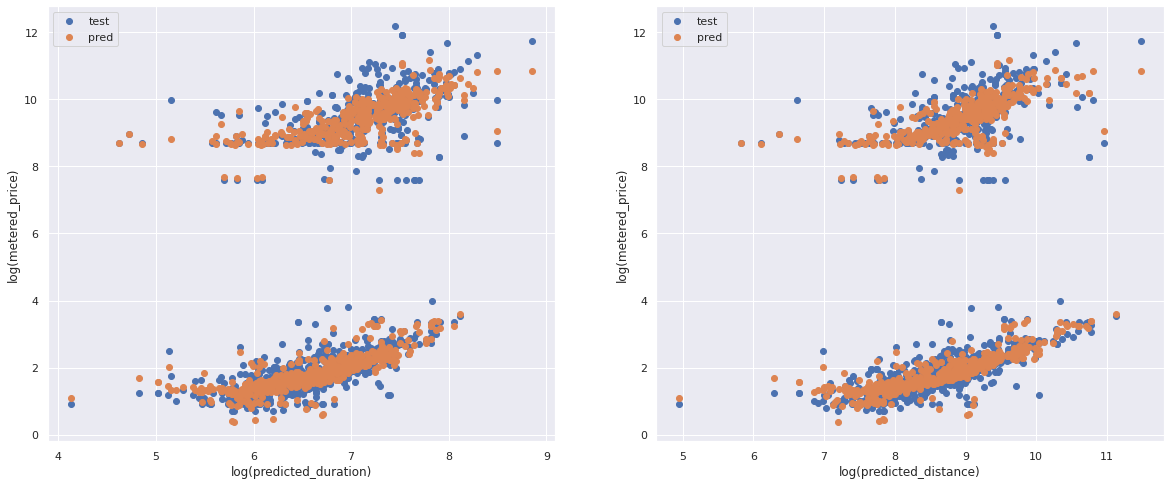

In [139]:
plot_results(X, y_pred, features_trips)

## Random Forest

In [1161]:
# steps = [
#     ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
#     ('scaler', StandardScaler()),
#     ('rf', lgb.LGBMRegressor('rf', subsample=0.6, subsample_freq=1))
# ]
# rf_pipe = Pipeline(steps)
# # rf_pipe.fit(X['train'], y['train'])
# # print_results(rf_pipe, X['test'], y['test'])

# param_grid = {
# #     'rf__bootstrap': [True],
#     'rf__max_depth': [60, 70, 80, 90],
#     'rf__n_estimators': [100, 200, 300, 1000]
# }
# grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
# grid_search.fit(X['train'], y['train'])
# print(grid_search.best_params_)
# best_grid = grid_search.best_estimator_
# y_pred = best_grid.predict(X['test'])
# print_results(best_grid, X['test'], y['test'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'rf__max_depth': 60, 'rf__n_estimators': 200}
R^2 = 0.98647
RMSE = 0.44914
Baseline RMSE = 0.42209


# NN

In [140]:
class TripDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y):
        steps = [
            ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
            ('scaler', StandardScaler())
        ]
        self.ridge_pipe = Pipeline(steps)
        self.X = self.ridge_pipe.fit_transform(X)
        self.shape = self.X.shape
        
        if not torch.is_tensor(self.X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(self.X)
            self.y = torch.from_numpy(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def transform(self, X):
        transformed = self.ridge_pipe.transform(X)
        if not torch.is_tensor(transformed):
             transformed = torch.from_numpy(transformed)
        return transformed
      

class Net(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 3 * n_hidden),
            nn.ReLU(),
            nn.Linear(3 * n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
    
def run_epoch(trainloader, net, optimizer, loss_function):
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = net(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0

In [141]:
labels = features_trips.loc[:, 'metered_price']
features = features_trips.drop(columns=['metered_price'])

X, y = train_test_split(features, labels, random_state=42)

In [147]:
# Set fixed random number seed
torch.manual_seed(42)

train_dataset = TripDataset(X['train'], y['train'])
# dataset = TripDataset(pd.DataFrame(X_train), pd.Series(y_train))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
net = Net(train_dataset.shape[1], 32, 1)
# net = Net(X_train.shape[1], 16, 1)

# Define the loss function and optimizer    
loss_function = RMSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  
# Run the training loop
for epoch in range(10):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    run_epoch(trainloader, net, optimizer, loss_function)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.195
Loss after mini-batch    11: 6.062
Loss after mini-batch    21: 6.415
Loss after mini-batch    31: 4.879
Loss after mini-batch    41: 3.385
Loss after mini-batch    51: 2.041
Loss after mini-batch    61: 1.843
Loss after mini-batch    71: 1.036
Loss after mini-batch    81: 0.981
Loss after mini-batch    91: 1.069
Loss after mini-batch   101: 0.790
Loss after mini-batch   111: 0.647
Loss after mini-batch   121: 0.822
Loss after mini-batch   131: 0.864
Loss after mini-batch   141: 1.135
Loss after mini-batch   151: 0.975
Loss after mini-batch   161: 0.756
Loss after mini-batch   171: 0.779
Loss after mini-batch   181: 0.707
Loss after mini-batch   191: 0.557
Loss after mini-batch   201: 0.559
Loss after mini-batch   211: 0.764
Loss after mini-batch   221: 0.851
Loss after mini-batch   231: 0.623
Loss after mini-batch   241: 0.613
Loss after mini-batch   251: 0.511
Loss after mini-batch   261: 0.615
Loss after mini-batch   271: 0.445
Los

Loss after mini-batch   341: 0.434
Loss after mini-batch   351: 0.512
Loss after mini-batch   361: 0.491
Loss after mini-batch   371: 0.436
Loss after mini-batch   381: 0.500
Loss after mini-batch   391: 0.625
Starting epoch 7
Loss after mini-batch     1: 0.058
Loss after mini-batch    11: 0.486
Loss after mini-batch    21: 0.513
Loss after mini-batch    31: 0.471
Loss after mini-batch    41: 0.514
Loss after mini-batch    51: 0.568
Loss after mini-batch    61: 0.492
Loss after mini-batch    71: 0.416
Loss after mini-batch    81: 0.481
Loss after mini-batch    91: 0.368
Loss after mini-batch   101: 0.458
Loss after mini-batch   111: 0.485
Loss after mini-batch   121: 0.605
Loss after mini-batch   131: 0.460
Loss after mini-batch   141: 0.565
Loss after mini-batch   151: 0.475
Loss after mini-batch   161: 0.387
Loss after mini-batch   171: 0.431
Loss after mini-batch   181: 0.408
Loss after mini-batch   191: 0.367
Loss after mini-batch   201: 0.443
Loss after mini-batch   211: 0.403
Los

In [148]:
y_pred = net(train_dataset.transform(X['test']).float()).detach().numpy().flatten()

In [149]:
rmse(y['test'], y_pred)

0.4974557641325022

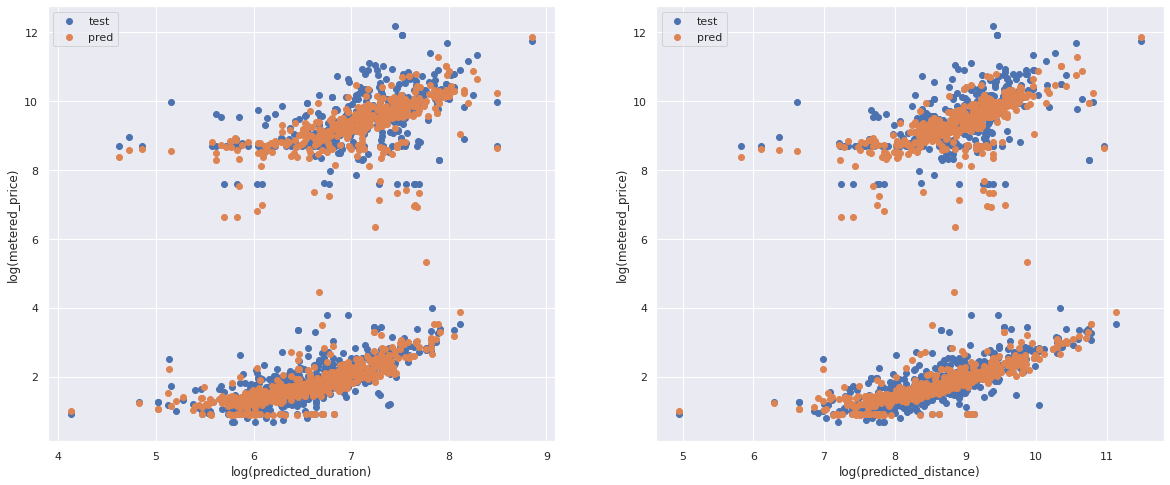

In [150]:
plot_results(X, y_pred, features_trips)